In [3]:
import pandas as pd 

Here we select 100 random sample ligands from BindingDB database to be used in experiments. 

In [141]:
sample_ligands = pd.read_csv('sample_ligands.csv', index_col=False)

In [144]:
sample_ligands['canonical_SMILES'].values.tolist()[:5]

['COc1ccc(-c2ccc3cnc(Nc4ccc(C5CCN(CC(N)=O)CC5)cc4OC)nn23)c(OC)c1',
 'C[C@@]1(c2cc(CNC3(C#N)CC3)c(F)cc2F)CCSC(N)=N1',
 'O=C(N1CCCC1)C(F)(F)c1ccc(-n2nc(C(F)(F)F)c3c2CCCC3)cc1',
 'O=S(=O)(Nc1ncns1)c1ccc2c(c1)OCCN2c1ccc(C(F)(F)F)cc1-c1cn[nH]c1',
 'OC[C@@H]1OC(n2cnc3c2N=CN2C[C@@H](Cc4ccccc4)N=C32)[C@@H](O)[C@H]1O']

In [9]:
ligand = sample_ligands['canonical_SMILES'].sample(1).values.tolist()[0]
ligand

'N[C@H]1C[C@@H](N2Cc3cnc(C4CC4)nc3C2)CC[C@@H]1c1cc(F)c(F)cc1F'

# Introduction to RDKit

RDKit is an open source toolkit for cheminformatics. 
* Reading/writing molecules
* Working with molecules. Looping over bonds and atoms.
* 2D/3D structures
* Substructure search
* Similarity search
* Descriptors calculation
* Structural and pharmacophore fingerprints
* Reactions and combinatorial libraries generation
* Drawing molecules

## Reading and Writing Molecules
RDKit supports various formats: SMILES, Mol, SDF, Mol2, PDB, FASTA, etc.

In [25]:
from rdkit import Chem
from rdkit.Chem import AllChem

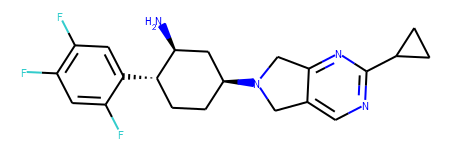

In [145]:
m = Chem.MolFromSmiles(ligand) # possible to read from smarts, mol, supplier etc.
m

While writing to SMILES, RDKit provides canonical SMILES but without chirality by default.

In [147]:
print(Chem.MolToSmiles(Chem.MolFromSmiles('C1=CC=CN=C1')))
print(Chem.MolToSmiles(Chem.MolFromSmiles('c1cccnc1')))
print(Chem.MolToSmiles(Chem.MolFromSmiles('n1ccccc1')))

c1ccncc1
c1ccncc1
c1ccncc1


In [148]:
print('Not isomeric\t', Chem.MolToSmiles(m, isomericSmiles=False)) 
print('Isomeric\t', Chem.MolToSmiles(m))
Chem.Kekulize(m)
print('Kekulized\t', Chem.MolToSmiles(m, kekuleSmiles=True))

Not isomeric	 NC1CC(N2Cc3cnc(C4CC4)nc3C2)CCC1c1cc(F)c(F)cc1F
Isomeric	 N[C@H]1C[C@@H](N2Cc3cnc(C4CC4)nc3C2)CC[C@@H]1c1cc(F)c(F)cc1F
Kekulized	 N[C@H]1C[C@@H](N2CC3=CN=C(C4CC4)N=C3C2)CC[C@@H]1C1=CC(F)=C(F)C=C1F


*The smiles provided when one requests kekuleSmiles are not canonical*

### Structure Sanitization
http://www.rdkit.org/docs/RDKit_Book.html#molecular-sanitization

RDKit performs a "sanitization" operation while reading molecules. 

2D and 3D Coordinates can be generated and stored with the molecule

In [27]:
#AllChem.Compute2DCoords(m)
#print(Chem.MolToMolBlock(m)) 

### Traverse Atoms and Bonds

In [40]:
print('Number of atoms\t\t', m.GetNumAtoms())
print('Bond type\t\t', m.GetBonds()[0].GetBondType())
print('Symbol\t\t\t', m.GetAtomWithIdx(0).GetSymbol())
print('Explicit valence\t', m.GetAtomWithIdx(0).GetExplicitValence())
print('Bond begin atom id\t', m.GetBondWithIdx(0).GetBeginAtomIdx())
print('Bond end atom id\t', m.GetBondWithIdx(0).GetEndAtomIdx())

atom = m.GetAtomWithIdx(0)
print('Atom at the begining:\t', atom.GetSymbol())
print('Atom\'s neighbors\t', [x.GetSymbol() for x in atom.GetNeighbors()])

Number of atoms		 28
Bond type		 SINGLE
Symbol			 N
Explicit valence	 1
Bond begin atom id	 0
Bond end atom id	 1
Atom at the begining:	 N
Atom's neighbors	 ['C']


In [48]:
ri = m.GetRingInfo()
ri.AtomRings()
ri.BondRings()

((27, 17, 16, 15, 2, 1),
 (4, 29, 14, 30, 5),
 (7, 8, 12, 13, 30, 6),
 (10, 31, 11),
 (20, 22, 24, 25, 28, 19))

In [42]:
Chem.GetSSSR(m) # smallest set of smallest rings

5

## Modifying molecules
RDKit stores the hydrogen atoms in molecules implicitly (not seen in the graph). Hydrogens could be made explicit as follows in case it is useful (e.g. generating 3D geometry)

In [49]:
m2 = Chem.AddHs(m)
m2.GetNumAtoms()

51

In RDKit, bonds in aromatic rings are assumed to be aromatic bonds in general. To change this, the molecule could be kekulized using rdkit.Chem.rdmolops.Kekulize() function:

In [152]:
m2 = Chem.MolFromSmiles('c1ccccc1')
print(m2.GetBondWithIdx(0).GetBondType())
Chem.Kekulize(m2)
print(m2.GetBondWithIdx(0).GetBondType())

AROMATIC
DOUBLE


Bonds can be restored to the aromatic bond type using the rdkit.Chem.rdmolops.SanitizeMol() function:

In [55]:
Chem.SanitizeMol(m2)
m2.GetBondWithIdx(0).GetBondType()

rdkit.Chem.rdchem.BondType.AROMATIC

## Drawing molecules

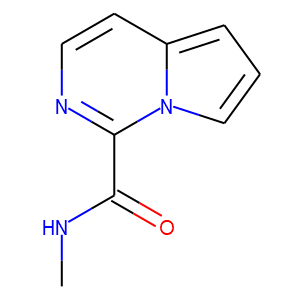

In [58]:
 Chem.Draw.MolToImage(m)  

## Substructure Searching
Substructure matching can be done using query molecules built from SMARTS or SMILES

In [155]:
m = Chem.MolFromSmiles('c1ccccc1O')
patt = Chem.MolFromSmarts('ccO')
print('Match ccO ?\t\t', m.HasSubstructMatch(patt))
print('Where ?\t\t', m.GetSubstructMatches(patt))
print('Match with COC ?\t', m.HasSubstructMatch(Chem.MolFromSmiles('COC')))

Match ccO ?		 True
Where ?		 ((0, 5, 6), (4, 5, 6))
Match with COC ?	 False


By default information about stereochemistry **is not used** in substructure searches. But this can be changed via the useChirality argument.

In [94]:
m = Chem.MolFromSmiles('CC[C@H](F)Cl')
print(m.HasSubstructMatch(Chem.MolFromSmiles('C[C@H](F)Cl')))
print(m.HasSubstructMatch(Chem.MolFromSmiles('C[C@@H](F)Cl'), useChirality=True))

True
False


### Substructure-based transformations
DeleteSubstructs, ReplaceSubstructs

## Murcko Scaffolds

The RDKit provides standard Murcko-type decomposition of molecules into scaffolds (Bemis et. al, 1996)

In [95]:
from rdkit.Chem.Scaffolds import MurckoScaffold

In [160]:
another_ligand = sample_ligands['canonical_SMILES'].sample(1).values.tolist()[0]
m = Chem.MolFromSmiles(another_ligand)
print('Ligand', another_ligand)
core = MurckoScaffold.GetScaffoldForMol(m)
Chem.MolToSmiles(core)

Ligand Cc1cc(C(N)=O)cc(C)c1C[C@H](N)C(=O)N1Cc2ccccc2C[C@H]1c1nc(-c2ccccc2)c[nH]1


'O=C(CCc1ccccc1)N1Cc2ccccc2C[C@H]1c1nc(-c2ccccc2)c[nH]1'

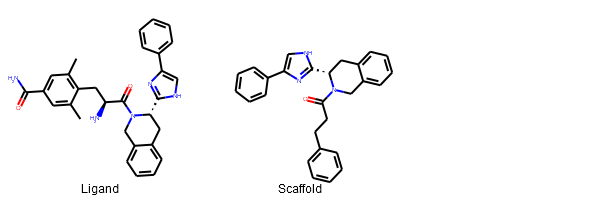

In [161]:
 Chem.Draw.MolsToGridImage([m, core],  legends=['Ligand', 'Scaffold'])

### Maximum Common Substructure

In [163]:
from rdkit.Chem import rdFMCS
mol1 = Chem.MolFromSmiles("O=C(NCc1cc(OC)c(O)cc1)CCCC/C=C/C(C)C")
mol2 = Chem.MolFromSmiles("CC(C)CCCCCC(=O)NCC1=CC(=C(C=C1)O)OC")
mol3 = Chem.MolFromSmiles("c1(C=O)cc(OC)c(O)cc1")
mols = [mol1,mol2,mol3]
res = rdFMCS.FindMCS(mols)
res.numAtoms, res.numBonds, res.smartsString

(10, 10, '[#6]1(-[#6]):[#6]:[#6](-[#8]-[#6]):[#6](:[#6]:[#6]:1)-[#8]')

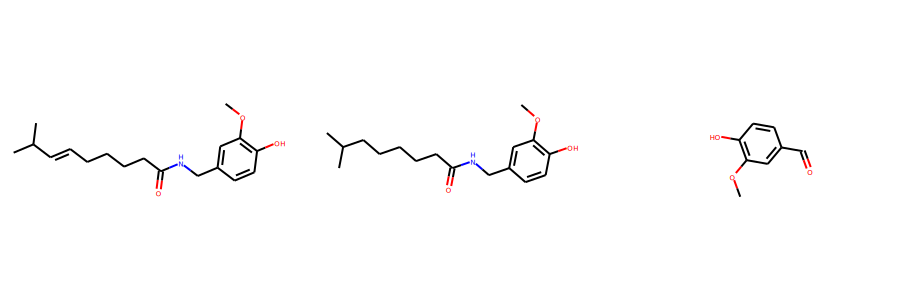

In [174]:
Draw.MolsToGridImage([mol1, mol2, mol3], subImgSize=(300, 300), useSVG=True)

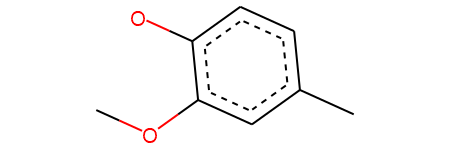

In [164]:
Chem.MolFromSmarts(res.smartsString)

### Fingerprinting and Molecular Similarity¶
![](https://www.researchgate.net/profile/Dong-Sheng_Cao/publication/235919348/figure/fig1/AS:299748008448007@1448476902809/Representation-of-a-molecular-substructure-fingerprint-with-a-substructure-fingerprint.png)

#### Topological Fingerprints
* Topological paths between pairs of atoms on a specified distance (defaults: min 1, max 7)
* Substructure fingerprint 

In [175]:
from rdkit import DataStructs
ms = [Chem.MolFromSmiles('CCOC'), Chem.MolFromSmiles('CCO'), Chem.MolFromSmiles('COC')]
fps = [Chem.RDKFingerprint(x) for x in ms]
DataStructs.FingerprintSimilarity(fps[0], fps[1])

0.6

#### Morgan (Circular Fingerprints)
* Circular topological fingerprints 
* Similarity fingerprint 

In [114]:
m1 = Chem.MolFromSmiles('Cc1ccccc1')
fp1 = AllChem.GetMorganFingerprint(m1,2)
m2 = Chem.MolFromSmiles('Cc1ncccc1')
fp2 = AllChem.GetMorganFingerprint(m2,2)
DataStructs.DiceSimilarity(fp1,fp2)

0.55

To measure similarity between molecules, the following metrics could be used: Tanimoto, Dice, Cosine, Sokal, Russel, Kulczynski, McConnaughey, and Tversky

#### Drawing images of fingerprints
The default highlight colors for the Morgan bits indicate:
    
    blue: the central atom in the environment

    yellow: aromatic atoms

    gray: aliphatic ring atoms

The default highlight colors for the RDKit bits indicate:

    yellow: aromatic atoms

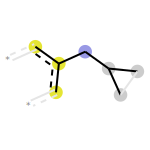

In [123]:
from rdkit.Chem import Draw
mol = Chem.MolFromSmiles('c1ccccc1CC1CC1')
bi = {}
fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, bitInfo=bi)
mfp2_svg = Draw.DrawMorganBit(mol, 872, bi, useSVG=True)
mfp2_svg

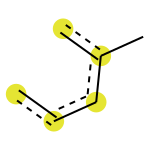

In [125]:
rdkbi = {}
rdkfp = Chem.RDKFingerprint(mol, maxPath=5, bitInfo=rdkbi)
rdk_svg = Draw.DrawRDKitBit(mol, 1553, rdkbi, useSVG=True)
rdk_svg

## Descriptors
https://www.rdkit.org/docs/GettingStartedInPython.html#list-of-available-descriptors

In [126]:
from rdkit.Chem import Descriptors
m = Chem.MolFromSmiles('c1ccccc1C(=O)O')
Descriptors.TPSA(m), Descriptors.MolLogP(m)

(37.3, 1.3848)

### Visualize descriptors
Similarity maps can be used to visualize descriptors that can be divided into atomic contributions.
Crippen contributions to logP is shown in the below figure.

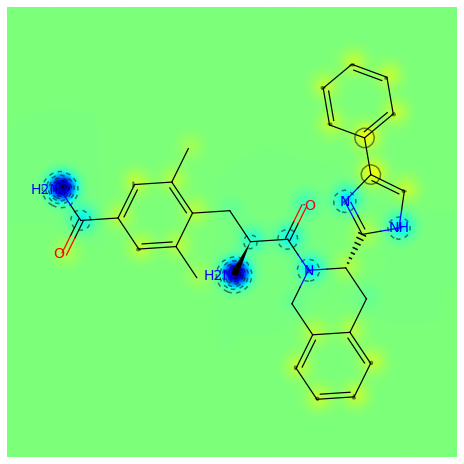

In [177]:
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem.Draw import SimilarityMaps
contribs = rdMolDescriptors._CalcCrippenContribs(m)
fig = SimilarityMaps.GetSimilarityMapFromWeights(m, [x for x, y in contribs], colorMap='jet', contourLines=8)

## Fragments

### Recap Implementation
Recap uses a set of chemical transformations mimicking common reactions carried out in the lab in order to decompose a molecule into a series of reasonable fragments.

In [129]:
from rdkit import Chem
from rdkit.Chem import Recap
m = Chem.MolFromSmiles('c1ccccc1OCCOC(=O)CC')
hierarch = Recap.RecapDecompose(m)

In [133]:
ks = hierarch.children.keys()
sorted(ks) # children of root

['*C(=O)CC', '*CCOC(=O)CC', '*CCOc1ccccc1', '*OCCOc1ccccc1', '*c1ccccc1']

In [131]:
ks=hierarch.GetLeaves().keys()
sorted(ks) # fragments at leaves

['*C(=O)CC', '*CCO*', '*CCOc1ccccc1', '*c1ccccc1']

### BRICS Implementation
BRICS provides another method for fragmenting molecules along synthetically accessible bonds

In [134]:
from rdkit.Chem import BRICS
sorted(BRICS.BRICSDecompose(m))

['[1*]C(=O)CC', '[16*]c1ccccc1', '[3*]O[3*]', '[4*]CC[4*]']

### Other fragmentation approaches
Here’s a quick demonstration of using that to break all bonds between atoms in rings and atoms not in rings.

In [136]:
m = Chem.MolFromSmiles('CC1CC(O)C1CCC1CC1')
bis = m.GetSubstructMatches(Chem.MolFromSmarts('[!R][R]')) #  finding all the atom pairs
bs = [m.GetBondBetweenAtoms(x,y).GetIdx() for x,y in bis] # get corresponding bond indices
nm = Chem.FragmentOnBonds(m,bs)
Chem.MolToSmiles(nm, True)

'*C1CC([4*])C1[6*].[1*]C.[3*]O.[5*]CC[8*].[7*]C1CC1'

## Chemical Features and Pharmacophores

In [138]:
from rdkit import Chem
from rdkit.Chem import ChemicalFeatures
from rdkit import RDConfig
import os
fdefName = os.path.join(RDConfig.RDDataDir,'BaseFeatures.fdef')
factory = ChemicalFeatures.BuildFeatureFactory(fdefName)

In [139]:
m = Chem.MolFromSmiles('OCc1ccccc1CN')
feats = factory.GetFeaturesForMol(m)
print(feats[0].GetFamily())
print(feats[0].GetType())
print(feats[0].GetAtomIds())
print(feats[4].GetFamily())
print(feats[4].GetAtomIds())

Donor
SingleAtomDonor
(0,)
Aromatic
(2, 3, 4, 5, 6, 7)


# References 

* http://www.rdkit.org/docs/index.html
* Bemis, G. W.; Murcko, M. A. “The Properties of Known Drugs. 1. Molecular Frameworks.” J. Med. Chem. 39:2887-93 (1996).
* Cao, Dong-Sheng & Xu, Qingsong & Hu, Qiannan & Liang, Yi-Zeng. (2013). manual for chemopy. 